**Modelo de red neuronal SVR**

Este archivo consta de los codigos de:
* 1.Carga de librerias y datos
* 2.Proceso de entrenamiento
  * 2.1. Separacion de datos en train y test
  * 2.2 Modelo SVR
* 3.Evaluacion del modelo
* 4.Exportar resultados


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [19]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

# import the model
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time,os
import joblib

In [20]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [21]:
cd /content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico

/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico


##Se obtiene conjunto de datos

In [22]:
predictor_variables=pd.read_csv('predictor_variables.csv' ,index_col='dt')
target_variables=pd.read_csv('target_variables.csv' ,index_col='dt')

In [23]:
#Setear semilla
np.random.seed(42)

#2.Proceso de entrenamiento

**Se establece los parametros de:**

In [24]:
#Se establece porcentaje de usado para test
PORCENTAJE_TEST=0.2

#Se define la cantidad de intentos de la optimizacion bayesiana
INTENTOS=100

##2.1. Separacion de data en train y test

In [25]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=PORCENTAJE_TEST, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


##2.2 Modelo SVR

In [26]:
# Definir la función objetivo
def objective(params):

    # Definir los hiperparámetros a optimizar
    kernel = params['kernel']
    gamma = params['gamma']
    C = float(params['C'])
    epsilon  = float(params['epsilon'])

    tscv = TimeSeriesSplit(n_splits=5)

    scores_mse = []
    scores_rmse = []
    scores_mae= []
    scores_mape= []
    times=[]
    aux=1000

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_, y_test_ = Y_train.iloc[train_index], Y_train.iloc[test_index]

      model_SVR = SVR(kernel = kernel, gamma =gamma, C =C, epsilon =epsilon )

      #Entrenamiento
      start = time.time()
      model_SVR.fit(X_train_, y_train_)
      end = time.time()

      #Evaluacion del modelo
      y_pred = model_SVR.predict(X_test)
      score_mse = mse(Y_test, y_pred)
      rmse = np.sqrt(score_mse)  # Calcular el RMSE
      score_mae = mae(Y_test, y_pred)
      score_mape= mape(Y_test, y_pred)

      scores_mse.append(score_mse)
      scores_mae.append(score_mae)
      scores_mape.append(score_mape)
      scores_rmse.append(rmse)

      if(score_mse<aux):
        aux=score_mse
        best_model=model_SVR

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(score_mse),
            'status': STATUS_OK,
            'model': model_SVR,
            'params': params,
            'time':times,
            'scores_mse': scores_mse,
            'scores_mae': scores_mae,
            'scores_mape': scores_mape,
            'scores_rmse': scores_rmse
            }

In [27]:
# Definir el espacio de búsqueda de hiperparámetros
space = {
    'kernel':hp.choice('kernel',['poly', 'rbf', 'sigmoid', 'linear']),
    'gamma': hp.choice('gamma', ['scale', 'auto'],),
    'C': hp.uniform('C', 0.1, 1),
    'epsilon': hp.uniform('epsilon', 0.1, 0.9),
}

In [28]:
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=INTENTOS, trials=trials)

print("Los mejores hiperparámetros son: ", best)

100%|██████████| 5/5 [00:00<00:00,  6.44trial/s, best loss: 0.3507002029765793]
Los mejores hiperparámetros son:  {'C': 0.7237300674663796, 'epsilon': 0.4787416155601423, 'gamma': 1, 'kernel': 1}


In [29]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
best_model = best_trial['result']['model']

In [30]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [31]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'C': 0.7237300674663796,
 'epsilon': 0.4787416155601423,
 'gamma': 'auto',
 'kernel': 'rbf'}

#3. Evaluacion de modelo

In [32]:
#Se realiza prediccion
results = best_model.predict(X_test)

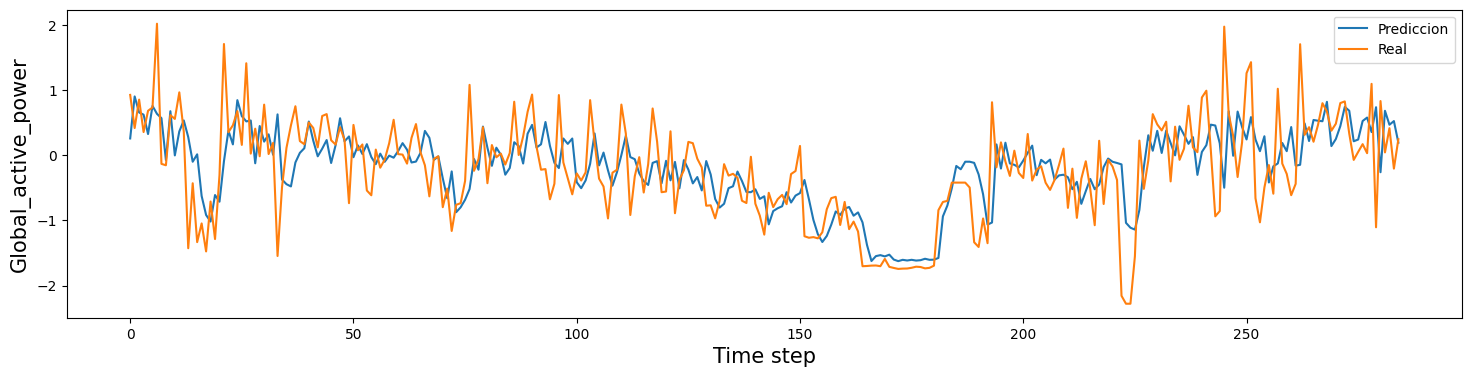

In [33]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

#4. Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [34]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  for time,score_mse,score_mae,score_mape,score_rmse in zip(result['time'],result['scores_mse'],result['scores_rmse'],result['scores_mae'],result['scores_mape']):
    k+=1
    nameModel = "SVR" + "_"+str(result['params']['kernel'])+"_"+str(result['params']['C'])+"_"+str(result['params']['epsilon'])+"_"+str(result['params']['gamma'])
    results.append([nameModel,trial,k,time,score_mse,score_rmse,score_mae,score_mape])

In [35]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
19,SVR_rbf_0.7237300674663796_0.4787416155601423_...,4,5,0.035366,0.350700,1.687385,0.592199,0.432314
24,SVR_rbf_0.37741598224180195_0.3272770473178799...,5,5,0.040732,0.353977,1.760676,0.594960,0.429912
23,SVR_rbf_0.37741598224180195_0.3272770473178799...,5,4,0.026584,0.367289,2.138108,0.606044,0.438030
14,SVR_linear_0.28508876503180136_0.3337248119302...,3,5,0.071499,0.379603,1.941115,0.616119,0.461723
18,SVR_rbf_0.7237300674663796_0.4787416155601423_...,4,4,0.024945,0.380768,2.399724,0.617064,0.459334


In [36]:
# Exportar el DataFrame como CSV
folder_path = '/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico/Resultados_csv'
csv_filename = 'results_SVR_CE'
csv_path = os.path.join(folder_path, csv_filename)
results_csv.to_csv(csv_path, index=False)

In [37]:
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico/Resultados_Modelos/results_SVR'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [38]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0

  nameModel = "SVR" + "_"+str(result['params']['kernel'])+"_"+str(result['params']['C'])+"_"+str(result['params']['epsilon'])+"_"+str(result['params']['gamma'])
  ruta = os.path.join(carpeta_destino, nameModel + ".pkl")
  joblib.dump(result['model'], ruta)
